# Задача обработки последовательности


Для начала вспомним, что основным подходом для работы с последовательностями до 2017 года (выхода оригинальной статьи про архитектуру «трансформер») было использование рекуррентных нейронных сетей, или RNN. Однако у такого подхода есть несколько известных минусов:

* Вся информация о последовательности хранится в скрытом состоянии, которое обновляется с каждым шагом.
* Обучение рекуррентных сетей сложно распараллелить: чтобы получить скрытое состояние RNN-слоя для шага i+1, вам необходимо вычислить состояние для шага i.

## Elman RNN (1990)

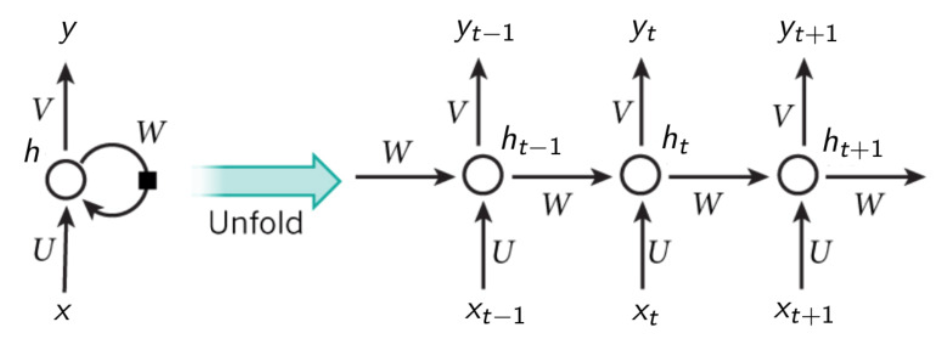

$$ h_t = \sigma \left( Ux_t + b_U+ Wh_{t-1} + b_W\right) $$
$$ y_t = \sigma \left( Vh_t + b_V\right) $$

Хочется иметь способ «читать» последовательность так, чтобы в каждый момент времени можно было обратиться к произвольному моменту из прошлого за константное время и без потерь информации. Таким способом и является лежащий в основе трансформеров механизм self-attention

## Seq2Seq RNN + Attention (2015)

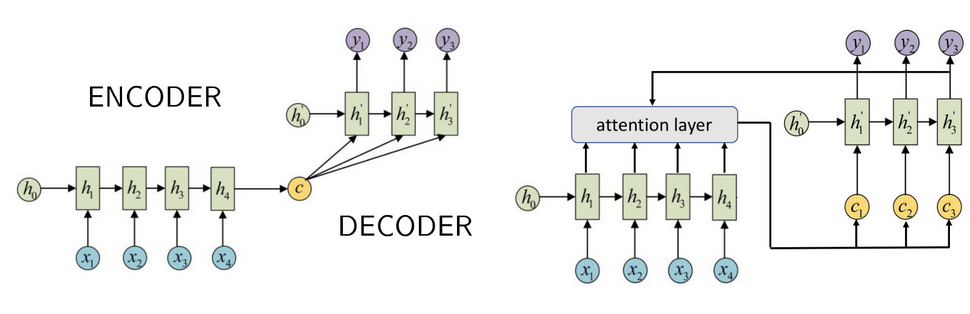

Механизм внимания вычисляет веса внимания $\alpha_{ti}$, которые показывают, насколько важно скрытое состояние $h_{i}$ энкодера для текущего шага декодера $t$.

$$\newcommand{\mathleft}{\@fleqntrue\@mathmargin0pt}
{
    h_i = f_{in}\left( x_i, h_{i-1} \right) \\
    α_{ti} = \frac{a \left( h_i, h^\prime_{t-1} \right)}{\sum_{k} a \left( h_k, h^\prime_{t-1} \right)} = norm_i a \left( h_i, h^\prime_{t-1} \right) \quad \text{--}  \quad \text{attention score} \\
    c_t = \sum_i \alpha_{ti} h_i \quad \text{--}  \quad \text{context vector} \\
    h^\prime_t = f_{out}\left( h^\prime_{t-1}, y_{t-1}, c_t \right) \\
    y_t = f_{y}\left( h^\prime_{t}, y_{t-1}, c_t \right)
}$$

Где $a \left( h, h^\prime \right)$ -- функция сходства состояния входа $h$ и выхода $h^\prime$.


*   $a \left( h, h^\prime \right) = h^\intercal h^\prime$
*   $a \left( h, h^\prime \right) = \exp \left( h^\intercal h^\prime \right)$
*   $a \left( h, h^\prime \right) = h^\intercal W h^\prime$

# Transformer

Ниже приведено устройство архитектуры «трансформер» из оригинальной [статьи](https://arxiv.org/pdf/1706.03762):

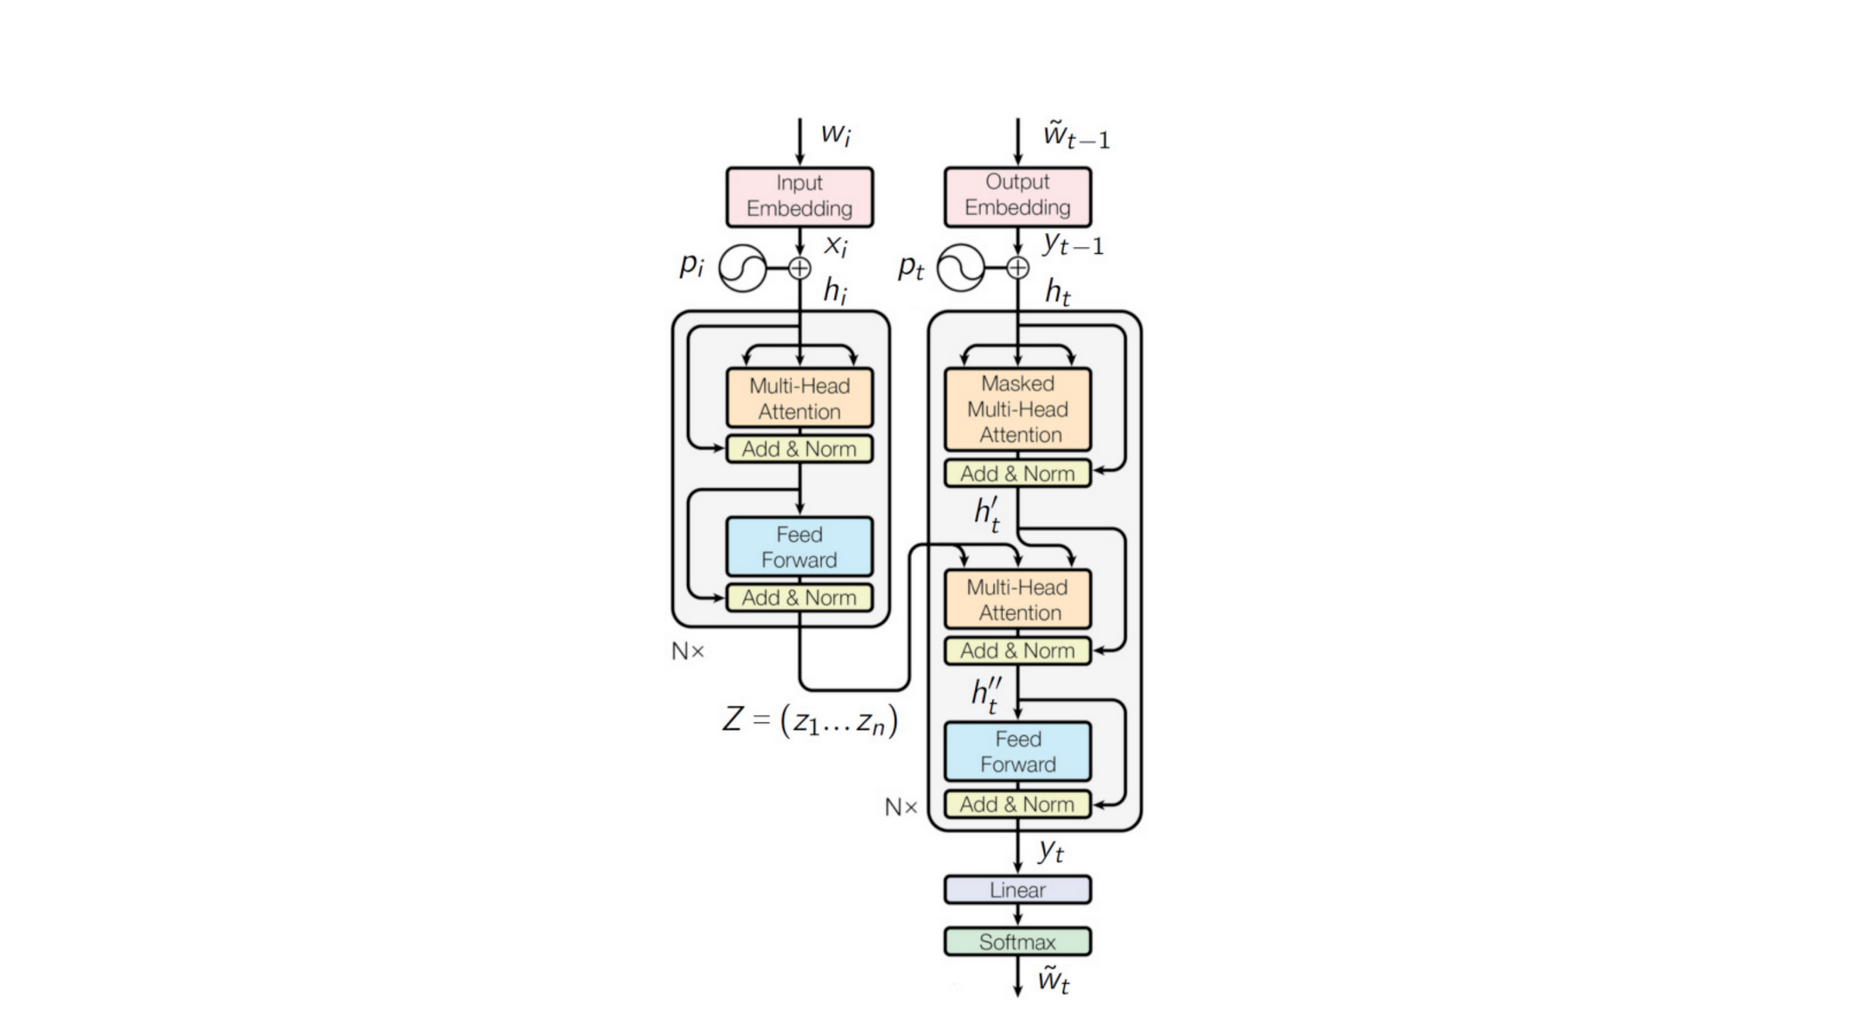

Стоит ознакомиться с разделом хэндбука от Яндекса: [Трансформеры](https://education.yandex.ru/handbook/ml/article/transformery)

## Обучаемое внимание (key, quary, value approach)


$$\newcommand{\mathleft}{\@fleqntrue\@mathmargin0pt}
{
    q_{t-1} = W_q h^\prime_{t-1} \qquad k_i = W_k h_i \qquad v_{i} = W_v h_i \\
    a \left( h_i, h^\prime_{t-1} \right) = k^\intercal_i q_{t-1} / \sqrt{d} \\
    \alpha_{ti} = SoftMax_i \, a \left( h_i, h^\prime_{t-1} \right) \\
    c_t = \sum_i \alpha_{ti} v_i
}$$


#### Как считать Self-Attention на практике

1. Можно не заводить отдельно три матрицы, поэтому можно сконкатенировать их в одну и посчитать все сразу:
$$
\hat W = [W_Q, W_K, W_V] \in ℝ^{H \times 3\hat H} \\
[Q,K,V] = \hat WX \\
Q,K,V = split([Q,K,V])
$$
На практике используется один слой Linear или одна матрица весов + reshape
2. Считать для каждой головы неоптимально, поэтому можно посчитать их одной матрицей через batched matmul
$$
reshape: Q,K,V \\
L\times H  ⟶ NH \times T \times H^{'} \\
scores = \frac{QK^T}{\sqrt d} \in NH \times T \times T
$$

где $NH$ - число голов

Отличие self-attention в **декодере**:
1. Этот слой получает на вход $K, V$ как результат работы энкодера
> $K^TV$ можно считать своеобразной базой данных, словарем, состоящим из ключа и значения, для которого мы делаем запрос
2. Чтобы слой не заглядывал в "будущее", применяется маскирование

Подробнее: [здесь](https://huggingface.co/blog/encoder-decoder)

### Виды внимания


*   **self-attention** - если $h^\prime_{t-1}  = h_t$
*   **masked self-attention** - тот же attention, но с маскированной частью входа
*   **multi-head attention** - если параллельно работает несколько голов внимания, а их вектора коонтекста как-либо "складываются"



#### Sparse Attention

В наивной постановке виден недостаток Self-Attention: слишком большая вычислительная сложность $O(T^2H)$ и сложность по памяти $O(T^2)$

Именно этот недостаток стремится исправить Sparse Attention:
1. Для большинства токенов $scores$ околонулевые
2. Ну так давайте не будем их считать и, возможно, хранить

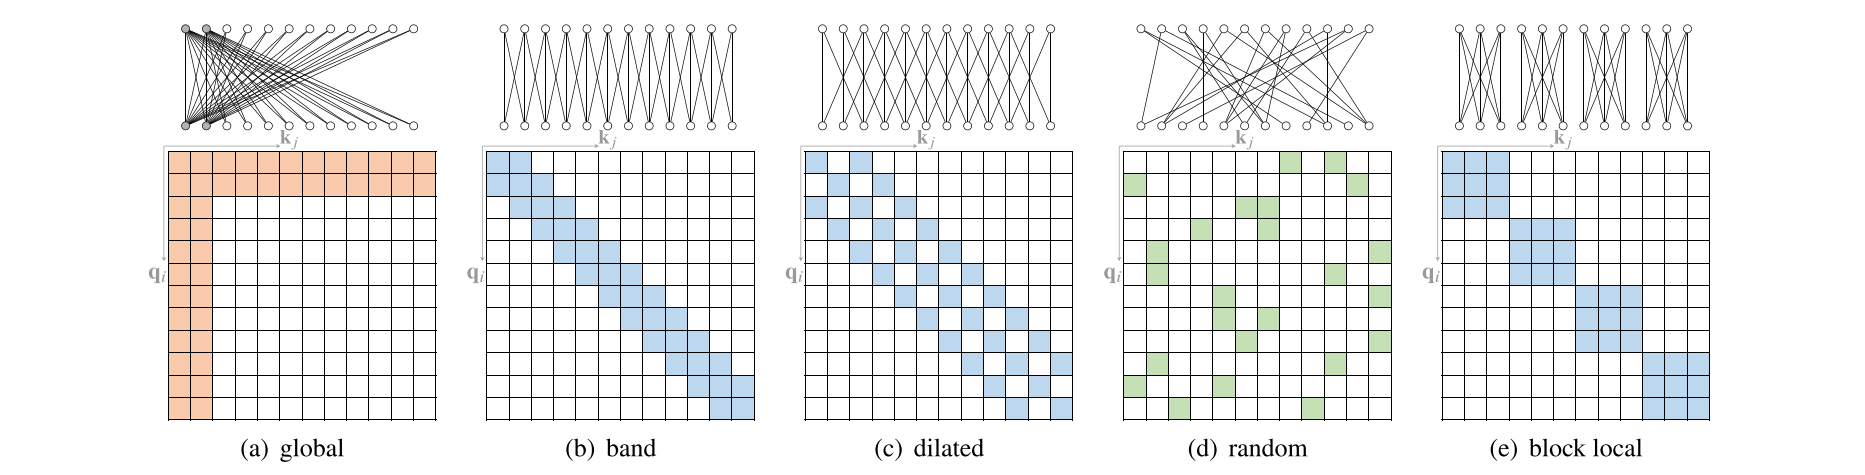

#### Flash Attention

* меньше чтений/записей в HBM
* параллелизации вычислений:
  - tiling: \( Q \), \( K \), \( V \) делятся на блоки, помещающиеся в RAM
  - Локальные softmax с коррекцией статистик.


[git](https://github.com/Dao-AILab/flash-attention)

In [ ]:
# Реальный Flash Attention использует рукописные ядра
def flash_attention(Q, K, V):
    for block_Q in Q:
        for block_K, block_V in zip(K, V):
            # Вычислить локальные scores
            S_block = block_Q @ block_K.T / sqrt(d_k)
            # Локальный softmax с коррекцией
            P_block = softmax(S_block)
            # Обновить выход блочно
            O += P_block @ block_V
    return O

## Positional encoding

В моделях типа Transformer (например, в BERT или GPT) отсутствует встроенная информация о порядке слов (в отличие от рекуррентных сетей). Чтобы модель понимала позицию слов в последовательности, используется **Positional Encoding** — специальное векторное представление, которое добавляется к эмбеддингам слов.

Позиции слов $i$ кодируются векторами $p_i$, $i=1,…,n$ и чем больше $|i-j|$, тем больше $\|p_i - p_j\|$
$$
p_{is} = \sin{i10^{-8\frac{s}{d}}} \quad p_{i, s+\frac{d}{2}} = \cos{i10^{-8\frac{s}{d}}}
$$

Примеры более современных способов позиционного кодирования : [Relative Position (2018)](https://arxiv.org/abs/1803.02155) и [RoPE (2021)](https://arxiv.org/abs/2104.09864)

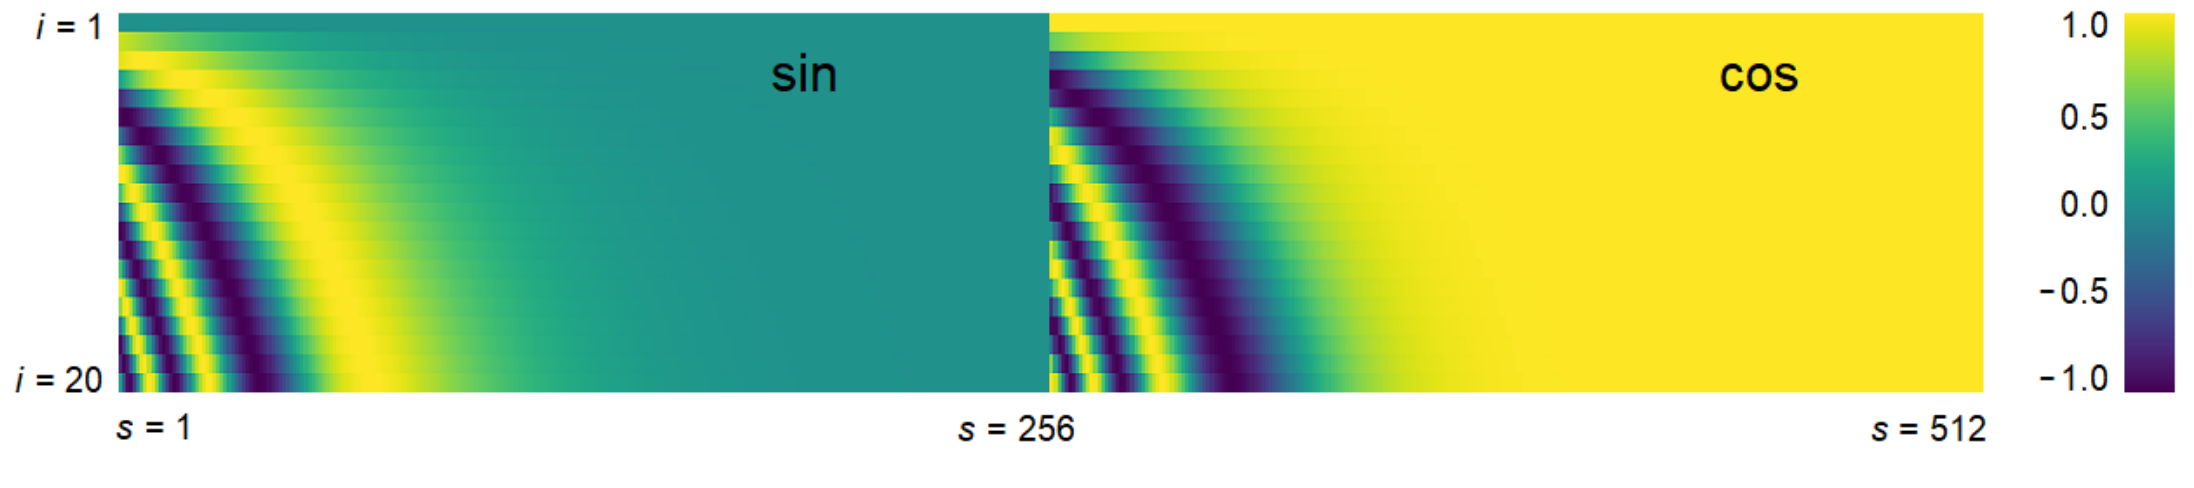

# BERT (2018) - encoder-only model

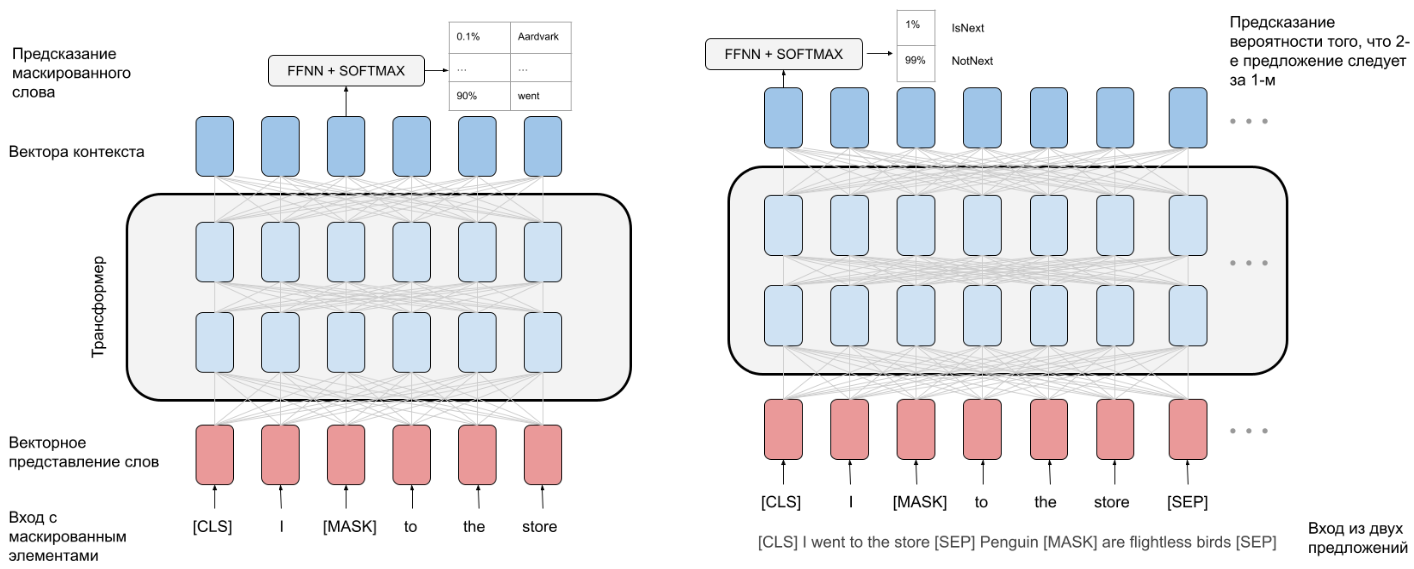

## BERT "понимает" грамматику и синтаксис языка

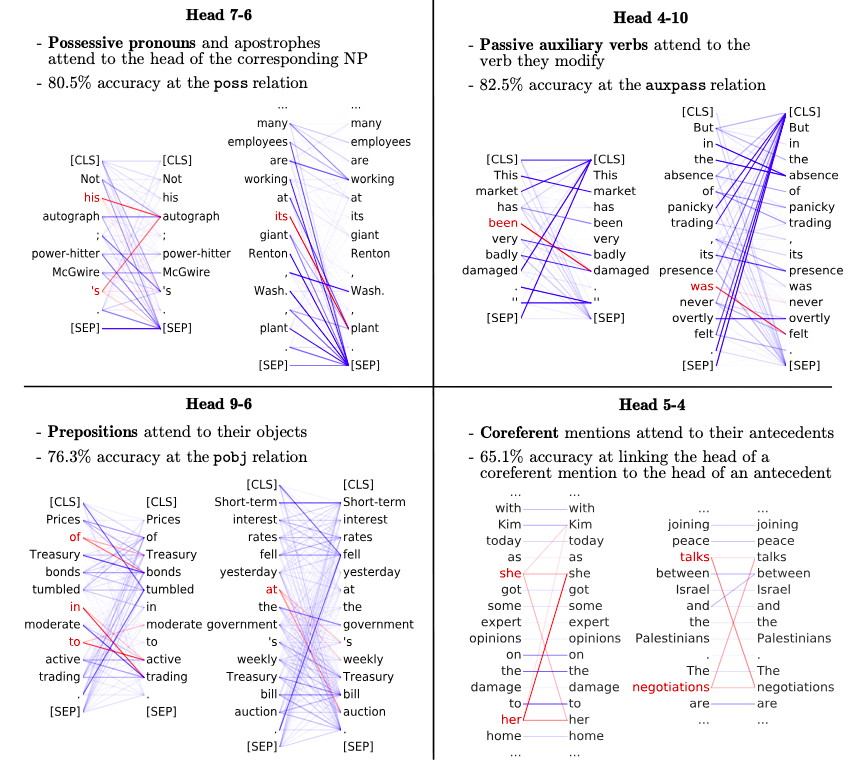

[What does BERT look at? An Analysis of BERT’s Attention / Clark et al. // 2019](https://aclanthology.org/W19-4828/)

# Практика

In [ ]:
!pip install -U datasets huggingface_hub fsspec

In [ ]:
!pip install transformers -qq

In [ ]:
!pip install evaluate -qq

In [ ]:
from typing import List, Tuple

In [ ]:
from datasets import load_dataset, Dataset
import evaluate
import numpy as np
from sklearn.metrics import classification_report
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from transformers import pipeline

## Pipeline дообучения модели

In [ ]:
SEED = 42

## Загрузим токенайзер

In [ ]:
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
seq = 'Привет о дивный новый мир!'
print(tokenizer.encode(seq))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode(seq)))

## Загрузим данные

In [ ]:
DATASET_NAME = 'Davlan/sib200'
DATASET_LANGUAGE = 'rus_Cyrl'
train_set = load_dataset(DATASET_NAME, DATASET_LANGUAGE, split='train')
validation_set = load_dataset(DATASET_NAME, DATASET_LANGUAGE, split='validation')
test_set = load_dataset(DATASET_NAME, DATASET_LANGUAGE, split='test')

In [ ]:
print(train_set)

## Токенизируем тексты

In [ ]:
MINIBATCH_SIZE = 64
tokenized_train_set = train_set.map(
    lambda it: tokenizer(it['text'], truncation=True),
    batched=True, batch_size=MINIBATCH_SIZE
)
tokenized_validation_set = validation_set.map(
    lambda it: tokenizer(it['text'], truncation=True),
    batched=True, batch_size=MINIBATCH_SIZE
)

In [ ]:
print(tokenized_train_set)

## Загрузим метрику для оценки качества модели на задаче классификации

In [ ]:
cls_metric = evaluate.load('f1')

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return cls_metric.compute(predictions=predictions, references=labels, average='macro')

## Создадим вспомогательный объект для трансформации данных в тензор

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Конвертируем категории в целевые метки

In [ ]:
# Задание

# Создаем отсортированный список уникальных категорий
# Создаем список индексов для каждой категории (0, 1, 2, ...) и считаем общее кол-во

# id2label
# label2id

In [ ]:
labeled_train_set = tokenized_train_set.add_column(
    'label',
    [label2id[val] for val in tokenized_train_set['category']]
)
labeled_validation_set = tokenized_validation_set.add_column(
    'label',
    [label2id[val] for val in tokenized_validation_set['category']]
)

In [ ]:
print(labeled_train_set)

## Загружаем наш BERT

In [ ]:
classifier = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=n_categories, id2label=id2label, label2id=label2id
)
# добавьте к строчке выше .cuda , чтобы отправить модель на видеокарту
for param in classifier.parameters(): param.data = param.data.contiguous()

## Визуализация attention

Локально можно визуализировать attention с помощью exbert: [huggingface превью](https://huggingface.co/spaces/exbert-project/exbert)

In [ ]:
!pip install bertviz

In [ ]:
from bertviz import head_view
from transformers import BertTokenizer, BertModel

model = BertModel.from_pretrained(MODEL_NAME, output_attentions=True) # нужны output_attentions

seq = 'Привет о дивный новый мир!'
inputs = tokenizer.encode_plus(seq, return_tensors='pt')
outputs = model(**inputs)
attention = outputs.attentions

head_view(attention, tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]))

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

## Этап обучения

In [ ]:
training_args = TrainingArguments(
    output_dir='rubert_sib200',
    learning_rate=2e-5,
    per_device_train_batch_size=MINIBATCH_SIZE,
    per_device_eval_batch_size=MINIBATCH_SIZE,
    num_train_epochs=20,
    weight_decay=1e-3,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    logging_steps = 5,
    # "warmup_ratio": 1/10,
    # "lr_scheduler_type": "cosine",
    # fp16=(device.type != 'cpu'),
    data_seed=SEED,
)

In [ ]:
trainer = Trainer(
    model=classifier,
    args=training_args,
    train_dataset=labeled_train_set,
    eval_dataset=labeled_validation_set,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

{'eval_loss': 0.4649854302406311,
 'eval_f1': 0.8517142429185567,
 'eval_runtime': 0.5145,
 'eval_samples_per_second': 192.415,
 'eval_steps_per_second': 3.887,
 'epoch': 20.0}

##  Оценим качество на отложенной выборке

In [ ]:
classifiсation_pipeline = pipeline('text-classification', model=classifier, tokenizer=tokenizer, device=0)

In [ ]:
y_pred = list(map(lambda x: x['label'], classifiсation_pipeline(test_set['text'])))
y_true = test_set['category']
print(classification_report(y_true=y_true, y_pred=y_pred))

                    precision    recall  f1-score   support

     entertainment       0.90      0.47      0.62        19
         geography       0.89      1.00      0.94        17
            health       0.91      0.91      0.91        22
          politics       0.97      0.97      0.97        30
science/technology       0.90      0.92      0.91        51
            sports       0.92      0.92      0.92        25
            travel       0.87      1.00      0.93        40

          accuracy                           0.91       204
         macro avg       0.91      0.88      0.89       204
      weighted avg       0.91      0.91      0.90       204



## Задание

Сравнить RuBERT выше с [sbert_large_nlu_ru](https://huggingface.co/ai-forever/sbert_large_nlu_ru)

# GPT - decoder-only model

Декодировщик трансформера, может быть очень большим: от 1B до 175B параметров

В качестве входного токенизатора использовали BPE, но только на бинарных символах Unicode

Начиная с GPT-2 декодировщики могли генерировать более-менее связный текст и **решать новые задачи без дополнительного дообучения**.

Так появились **большие языковые модели (Large Language Models, LLM)**. А нас стало интересовать, как и насколько хорошо их знания переносятся на новые задачи

1. Zero-Shot Learning - модель пишет ответ только на основании задания, написанного на естественном языке или оформленного в JSON или другой вспомогательный формат

> Формулировка задания называется prompt'ом или затравкой

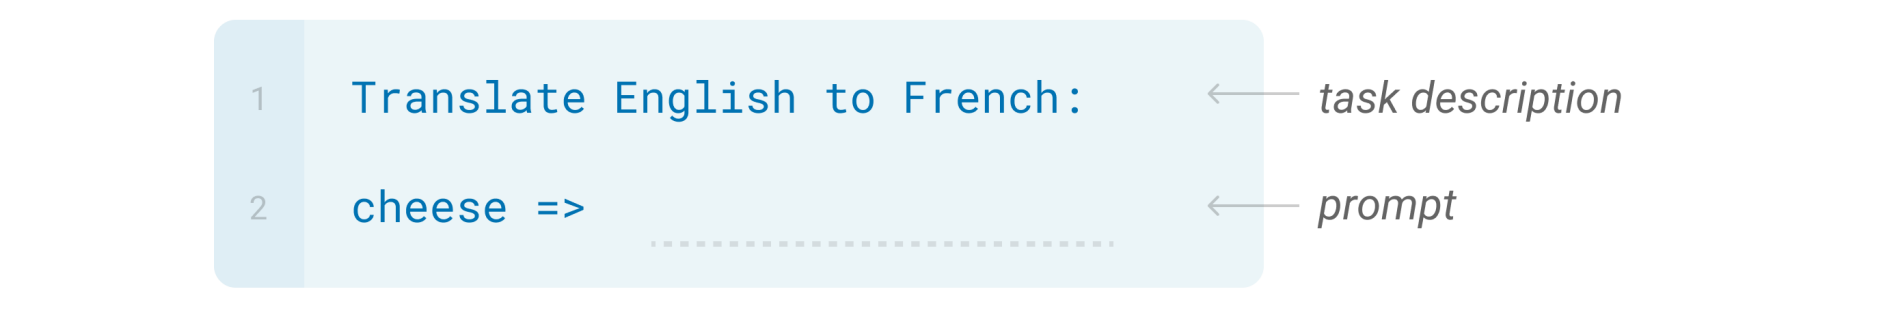

2. One-Shot - вдобавок к самому заданию модель видит один из примеров решения

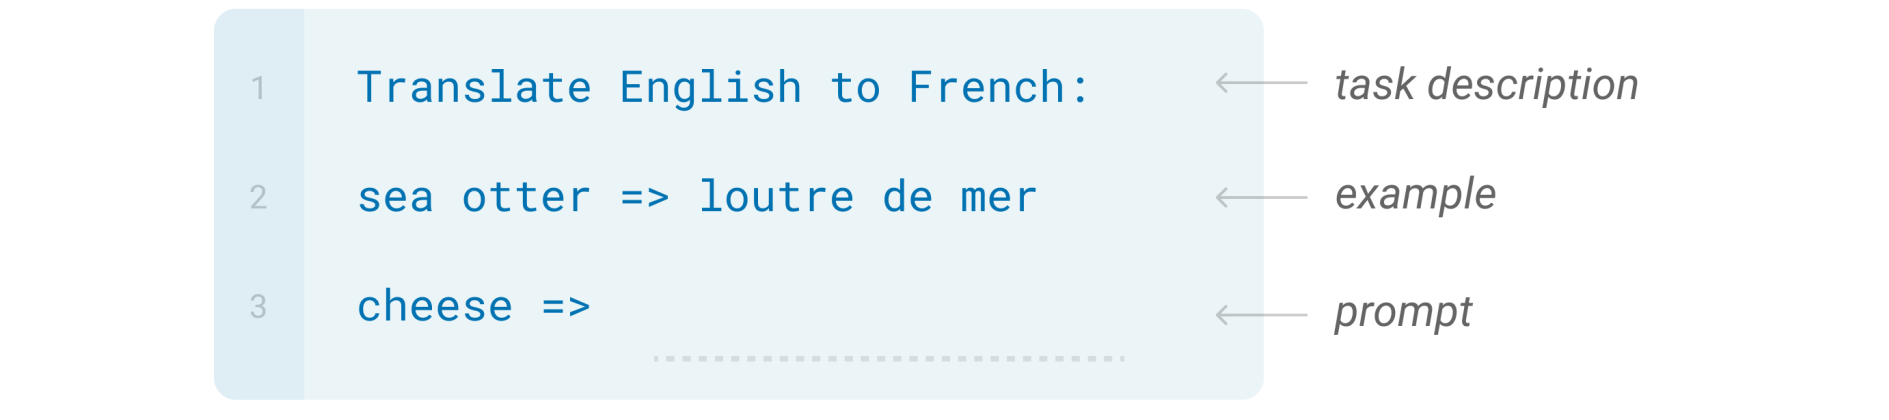

3. Few-Shot - модель видит несколько примеров решения

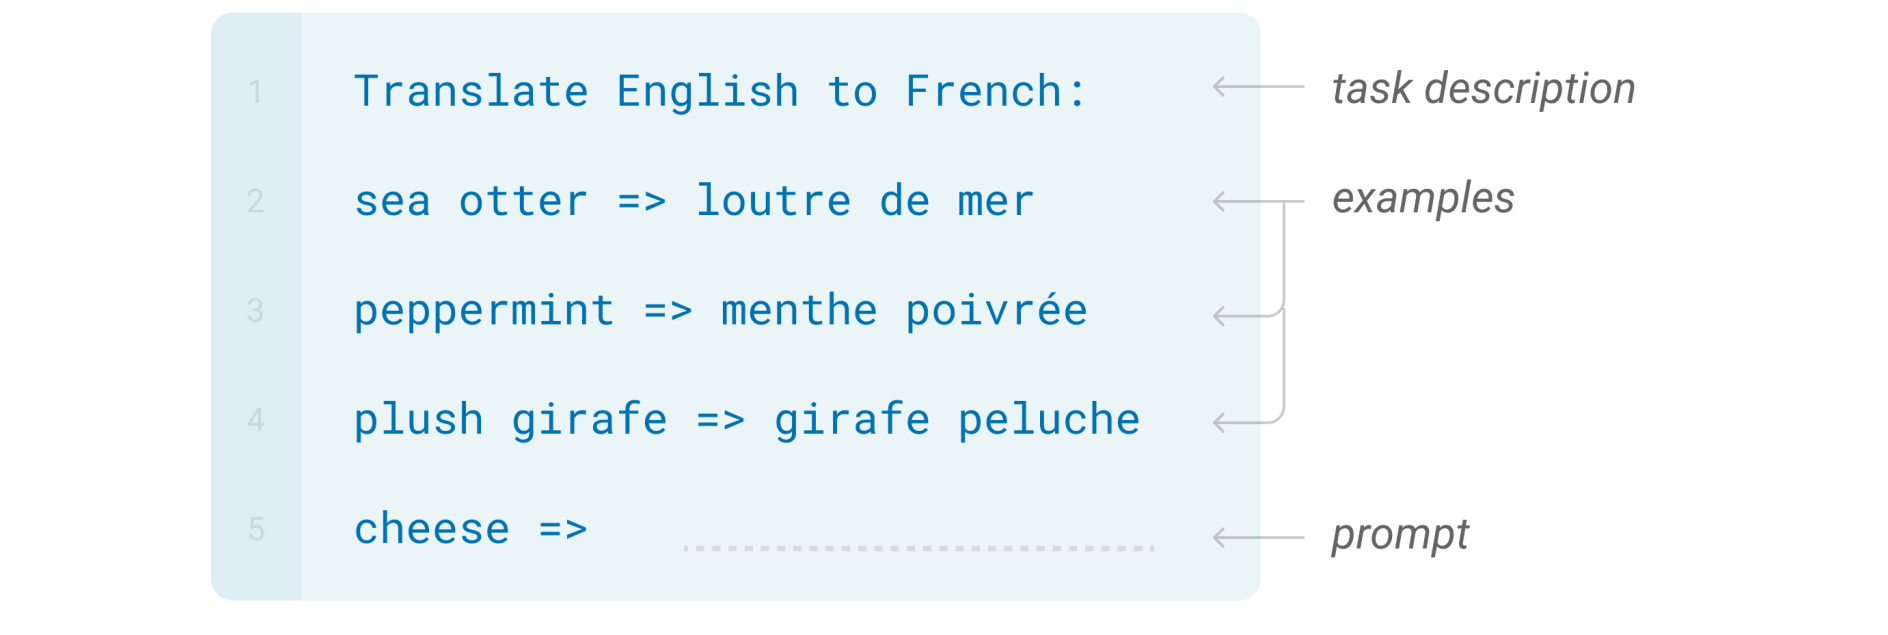

Кроме способности к Zero-Shot / Few-Shot работа модели также опеределяется:
1. Затратами на обучение: насколько эффективную модель можно обучить при фиксированных ресурсах на обучение
2. Эффективность инференса: насколько умную модель можно обучить при фиксированных ресурсах на инференс

Достоинства GPT:
1. Мы учимся предсказывать 100% токенов в teacher forcing - это очень эффективно с точки зрения скорости сходимости
2. Умеет работать в Zero и Few-Shot

Недостатки:
1. Не использует правый контекст при генерации
2. Не может изменять уже сгенерированные токены
3. Потокенная генерация достаточно долгая

Итоговая метрия почти линейно зависит от размера модели (в данном случае - от числа увиденных токенов) - **scaling law**

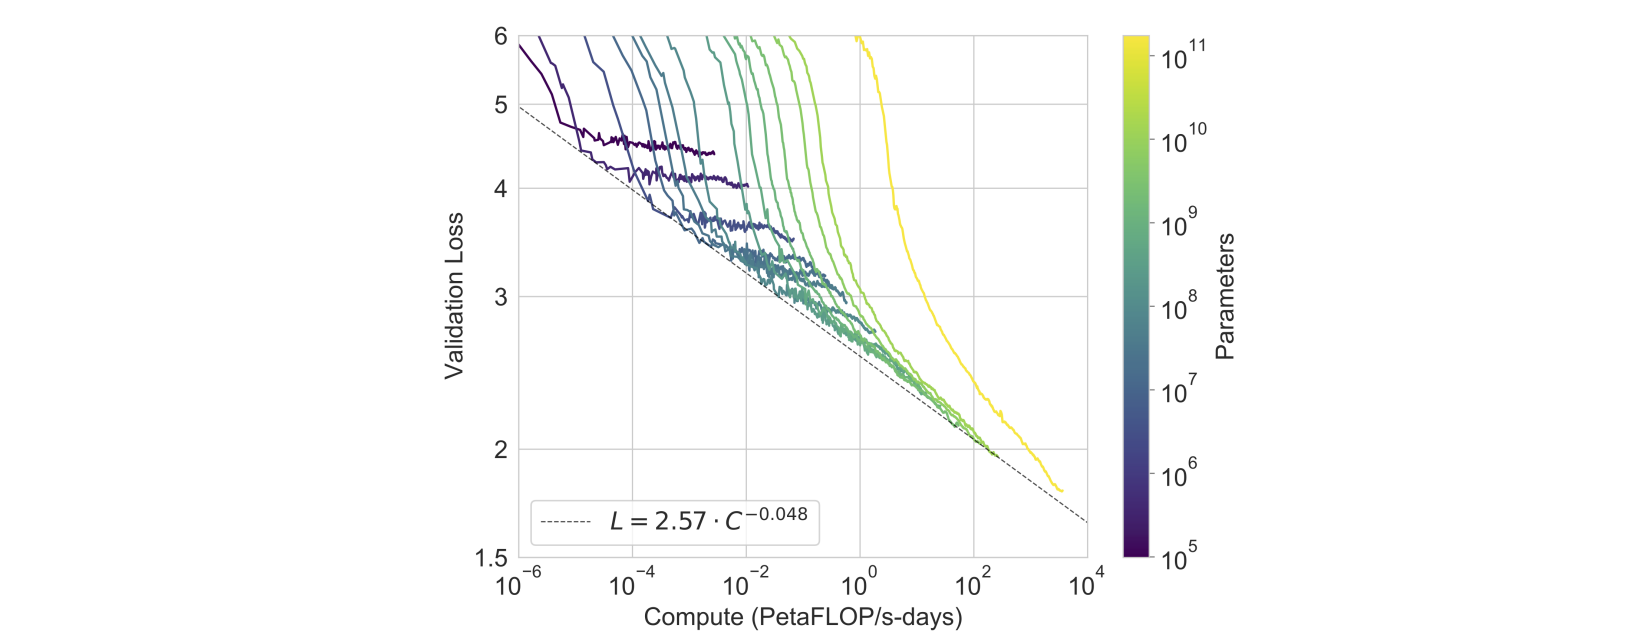

Почему вообще возможен *in-context learning* в Zero & Few-Shot задачах:
1. Трансформерные модели выступают в виде [метаоптимизаторов](https://proceedings.mlr.press/v202/von-oswald23a/von-oswald23a.pdf), выполняющий SGD внутри self-attention слоя
2. Причем число слоев эквивалентно числу шагов оптимизатора, а с течением обучения ранг тензора обновления становится все больше
3. Они не только делают "fine-tune" внутни контекста токенов. FFN в трансформере - аналог [памяти](https://arxiv.org/pdf/2012.14913.pdf) для Key-Value пар.
$$
y^l = \sum_i ReLU(x^lk_i^l)v_i^l + b^l
$$
Поэтому метаоптимизация идет по всей памяти, а чем глубже и шире архитектура, тем ее больше  

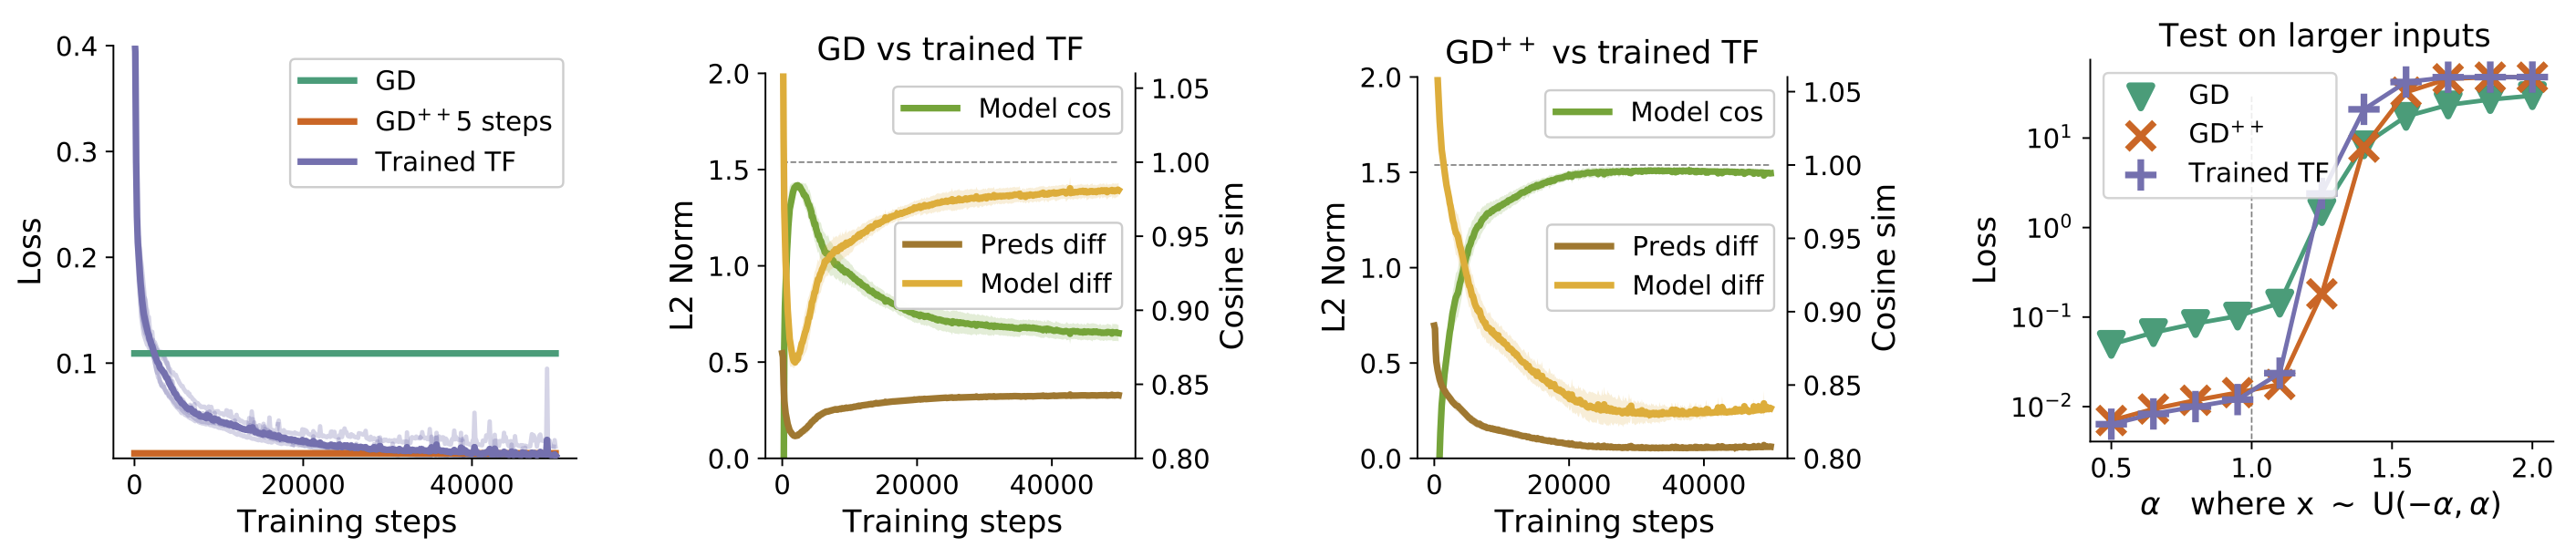

# Полный Transformer: T5

Многие задачи можно сформулировать в виде sequence-to-sequence: классификация, перевод, распознавание именованных сущностей, языковое моделирование, суммаризация

Достоинства:
1. Благодаря энкодеру могут более точно поддерживать контекст
2. Быстрее, чем decoder-only, потому что можно сделать декодер небольшим за счет большого энкодера (как, например, в DistillWhisper)